In [131]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from data_collection.parse_pcap import pcap_to_pandas

# Nearest Neighbors

Today we'll investigate whether a network eavesdropper can use device traffic to infer what people are doing inside their homes. We will pretend to be the eavesdropper and use a nearest neighbors classifier to perform this attack. We'll discuss what makes this algorithm effective, why this constitutes a privacy risk, and how we can protect device owners.

### Overview

Nearest neighbors is an AI algorithm that operates on a very simple premise: Objects of one type are more likely to be similar to other objects of the same type than to objects of any different type. Stated with a concrete example: "Dogs are generally more similar to other dogs than they are to cats." 

This intuition translates naturally into a classification algorithm. If you have a labeled training set (objects with associated types) and you want to predict the label for a new object, find the $k$ objects in the training set that are most similar to the new object and predict the label of the majority of these $k$ closest objects. 

Consider the following graphical example with three classes of objects represented as 2D points colored by class. In this case, and for nearest neighbors in general,we consider "most similar" to mean "closest," typically computed as the Euclidean distance between points. If you wanted to predict the class of the black star, using the closest point (1-nearest neighbor), what would be the prediction? How about if you used the 5 closest points (5-nearest neighbors)?

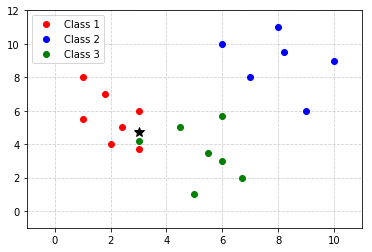

In [52]:
class1 = [(1, 8), (2.4, 5), (3,6), (2,4), (1.8, 7), (3, 3.7), (1, 5.5)]
class2 = [(7,8), (9, 6), (10, 9), (6,10), (8,11), (8.2,9.5)]
class3 = [(5,1), (6, 3), (6, 5.7), (4.5,5), (5.5,3.5), (6.7, 2), (3,4.2)]
unknown = [(3, 4.7)]
plt.plot(*zip(*class1), '.', color='red', markersize=12, label="Class 1")
plt.plot(*zip(*class2), '.', color='blue', markersize=12, label="Class 2")
plt.plot(*zip(*class3), '.', color='green', markersize=12, label="Class 3")
plt.plot(*zip(*unknown), '*', color='black', markersize=10)
plt.xlim((-1,11))
plt.ylim((-1,12))
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

This same technique generalizes to objects that have more features (higher dimensionality). It's hard to plot a 10 dimensional point, but the distance function works in arbitrarily high dimensions, so you can still find nearest neighbors. 

### Application to IoT Privacy

In order to apply nearest neighbors to our IoT device network data we need to take the following steps:
1. Convert the lists of packets into points, with each point encapsulating the device's network activity at a particular time and associate each point with a label (the activity you were doing with the device at the time of the point). 
2. Divide the points into a training set and a test set and train a K-Nearest Neighbors classifier. In reality, "train" is a bit of a misnomer for nearest neighbors classifiers, because all that happens is that the points get stored for comparision. No math actually takes place.
3. Predict the labels of the test set using the classifier and calculate the accuracy of the predictions against the real labels.
4. Adjust parameters to improve accuracy.

#### 1. Import data and convert to points

In [85]:
pcap = pcap_to_pandas('example_pcaps/google_home.pcap') # this can take a few minutes
pcap.head(n=2)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2017-12-07 15:48:41.156083,None,None,None,NaN,None,NaN,False,113,a4:77:33:2f:e0:6e,180831866839150,b8:27:eb:2d:24:15,202481588839445,NaN,NaN,None,1.512680e+09,0.000000
1,2017-12-07 15:48:41.255304,None,None,None,NaN,None,NaN,False,135,b8:27:eb:2d:24:15,202481588839445,a4:77:33:2f:e0:6e,180831866839150,NaN,NaN,None,1.512680e+09,0.099221


The data is currently stored as a list of packets, but we want it as points corresponding to time periods. 

Let's clean up the data a bit first. First, let's filter out all packets not sent by the device. Second, let's assume that the attacker is outside the home and only has access to IP traffic. Third, let's assume that the attacker only has access to the time each packet was sent and its length (this is a reasonable assumption for encrypted traffic, as we will discuss). 

In [118]:
device_mac_address = ''
device_packets = pcap.loc[pcap['mac_src'] == device_mac_address]

ip_packets = device_packets.loc[device_packets['ip_src'].notnull()]
ip_packets = ip_packets.loc[ip_packets['ip_src'] != '0.0.0.0']
ip_packets = ip_packets.loc[ip_packets['ip_dst'] != '0.0.0.0']

time_packets = ip_packets[['time', 'length']]
time_packets.head(n=3)

,time,length
9,1.512680e+09,62
10,1.512680e+09,342
12,1.512680e+09,342


Looks good, but why are the packet times just large numbers? These numbers are times in units of seconds since the "epoch" (January 1, 1970 at 00:00:00 GMT), a common format for computer timestamps. Let's convert them to normal-looking times.

In [132]:
time_packets["datetime"] = [datetime.fromtimestamp(t) for t in time_packets['time']]
time_packets.head(n=3)

,time,length,datetime
9,1.512680e+09,62,2017-12-07 15:48:44.186461
10,1.512680e+09,342,2017-12-07 15:48:44.186628
12,1.512680e+09,342,2017-12-07 15:48:44.220229


Now let's convert the list of packets into send rates by calculating the total amount of data sent (sum of packet lengths) during equal length time windows. 

Next let's divide these rates into individual points we can associate with a specific activity by dividing the list of rates into longer time periods. The TAs will draw this on the board.

Whew, now we have points. Next let's import the activity labels. 

In [ ]:
labels = load_labels('example_pcaps/google_home_labels.txt')
labels.head(n=2)

We need to associate the labels with the points based on the timestamps

Whew, now we have both labels and points. As is often the case with AI, data preprocessing turns out to be the hardest step in the process. Since our points have more than three dimensions, they are hard to visualize. Let's try to get a sense of them by plotting them in 2D using a transformation called "Principle Component Analysis" (which we will explain on the board). 

This is a bit messy, but when you collapse high dimensional data into 2D, much of the space between the data is lost. 
Nevertheless what is your impression of the data? Are points of the same class closer to each other than to points of other classes? How well do you think that the nearest neighbors classifier will work? 

#### 2. Train k-nearest-neighbors classifier

Let's divide the points into a training set and a test set. 

Now we can train the classifier on the training set.

#### 3. Calculate accuracy on test set

Let's predict the labels for the test set points using the trained classifier and compare the predicted labels to the actual labels

#### 4. Adjust parameters to improve accuracy.

Now that we have a baseline accuracy, we can tweak the data preprocessing and classifier parameters to improve the accuracy. Look back through the code we've run so far. Which values have we set arbitrarily that could affect the results? 

Try changing these parameters and re-running the code to see how the classification accuracy is affected. If we have time (or for homework tonight), copy the code we've run so far into the cell below, and wrap it in a loop that automatically changes parameter values. Save the resulting accuracies in a list and plot the list (accuracies on the y-axis, parameters on the x-axis). 

#### Discussion